# Setting Up

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/CarePlan-Data/Time_series_data/New-Data")

Mounted at /content/drive


In [2]:
pip install -U keras-tuner

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=9f19993febac47b1039c4e499b3bd80ef3ff827ff5a4624b29e87fcff2275ca6
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=f7ce0ebd1fe3a368ce6b72d37058354b24a09937f64d1dcdb5dc78c6df98da84
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization
import seaborn as sns
from pylab import rcParams
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.0)

rcParams['figure.figsize'] = 22, 10
from kerastuner.tuners import RandomSearch
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
import matplotlib.dates as mdates

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data Preprocessing

In [56]:
df = pd.read_excel('Sample_CGM4Dashboard.xlsx')

In [5]:
df.head()

,Patient ID,Date,Time,GlucoseValue,Data type,Abnormal,p-value,condince interval-lower bound,confidence interval-upper bound
0,205,2019-08-09,16:16:57,350,real,NaN,NaN,NaN,NaN
1,205,2019-08-09,15:16:58,351,real,NaN,NaN,NaN,NaN
2,205,2019-08-09,06:16:59,181,real,NaN,NaN,NaN,NaN
3,205,2019-08-09,14:16:58,293,real,NaN,NaN,NaN,NaN
4,205,2019-08-09,13:16:58,218,real,NaN,NaN,NaN,NaN


In [57]:
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.floor('T').dt.time
df.Time=df.Time.astype('str')
df.drop(columns=['Data type','Abnormal','p-value','condince interval-lower bound','confidence interval-upper bound'],inplace=True)
df.Date=df.Date.astype('str')
df['Date']=pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.drop(columns=['Time'],inplace=True)
df.sort_values(by='Date', ascending=True,inplace=True)
# df.rename(columns={'Date':'ds','GlucoseValue':'y'},inplace=True)
# df1=df.copy()

In [58]:
df.head(11)

,Patient ID,Date,GlucoseValue
3914,116,2019-08-09 00:16:00,179
9288,106,2019-08-09 00:16:00,125
8284,146,2019-08-09 00:16:00,125
5064,181,2019-08-09 00:16:00,185
2717,135,2019-08-09 00:16:00,214
7247,188,2019-08-09 00:16:00,199
6211,227,2019-08-09 00:16:00,136
16,205,2019-08-09 00:16:00,223
1348,77,2019-08-09 00:16:00,136
3924,116,2019-08-09 01:16:00,180


In [62]:
df1=df[df['Patient ID'] == 188] 

In [63]:
df1.head()

,Patient ID,Date,GlucoseValue
7247,188,2019-08-09 00:16:00,199
7246,188,2019-08-09 01:16:00,213
7245,188,2019-08-09 02:16:00,204
7244,188,2019-08-09 03:16:00,177
7243,188,2019-08-09 04:16:00,175


In [64]:
df1.drop(columns='Patient ID',inplace=True)
df1.rename(columns={'Date':'ds','GlucoseValue':'y'},inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [65]:
df1

,ds,y
7247,2019-08-09 00:16:00,199
7246,2019-08-09 01:16:00,213
7245,2019-08-09 02:16:00,204
7244,2019-08-09 03:16:00,177
7243,2019-08-09 04:16:00,175
...,...,...
8270,2019-09-21 19:16:00,211
8269,2019-09-21 20:16:00,293
8279,2019-09-21 21:16:00,333
8278,2019-09-21 22:16:00,261


In [ ]:
# df1.to_csv('df1.csv')

In [10]:
# Python
import itertools
import numpy as np
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation


cutoffs = pd.to_datetime(['2019-08-09 18:16:00', '2019-08-19 13:16:00', '2019-08-29 01:16:00'])
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df1)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd2fb9d5198>
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd2fe0c7470>
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd2fba52ba8>
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbp

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01   330.610365
1                     0.001                     0.10   237.313993
2                     0.001                     1.00  2018.187866
3                     0.001                    10.00   219.092369
4                     0.010                     0.01   325.186605
5                     0.010                     0.10   249.193618
6                     0.010                     1.00  2204.707458
7                     0.010                    10.00   203.239632
8                     0.100                     0.01   322.115045
9                     0.100                     0.10   249.439710
10                    0.100                     1.00  2202.078192
11                    0.100                    10.00   204.607145
12                    0.500                     0.01   735.392784
13                    0.500                     0.10   256.115744
14        

In [11]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01   330.610365
1                     0.001                     0.10   237.313993
2                     0.001                     1.00  2018.187866
3                     0.001                    10.00   219.092369
4                     0.010                     0.01   325.186605
5                     0.010                     0.10   249.193618
6                     0.010                     1.00  2204.707458
7                     0.010                    10.00   203.239632
8                     0.100                     0.01   322.115045
9                     0.100                     0.10   249.439710
10                    0.100                     1.00  2202.078192
11                    0.100                    10.00   204.607145
12                    0.500                     0.01   735.392784
13                    0.500                     0.10   256.115744
14        

In [12]:
# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


In [ ]:
len(df1)

1056

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


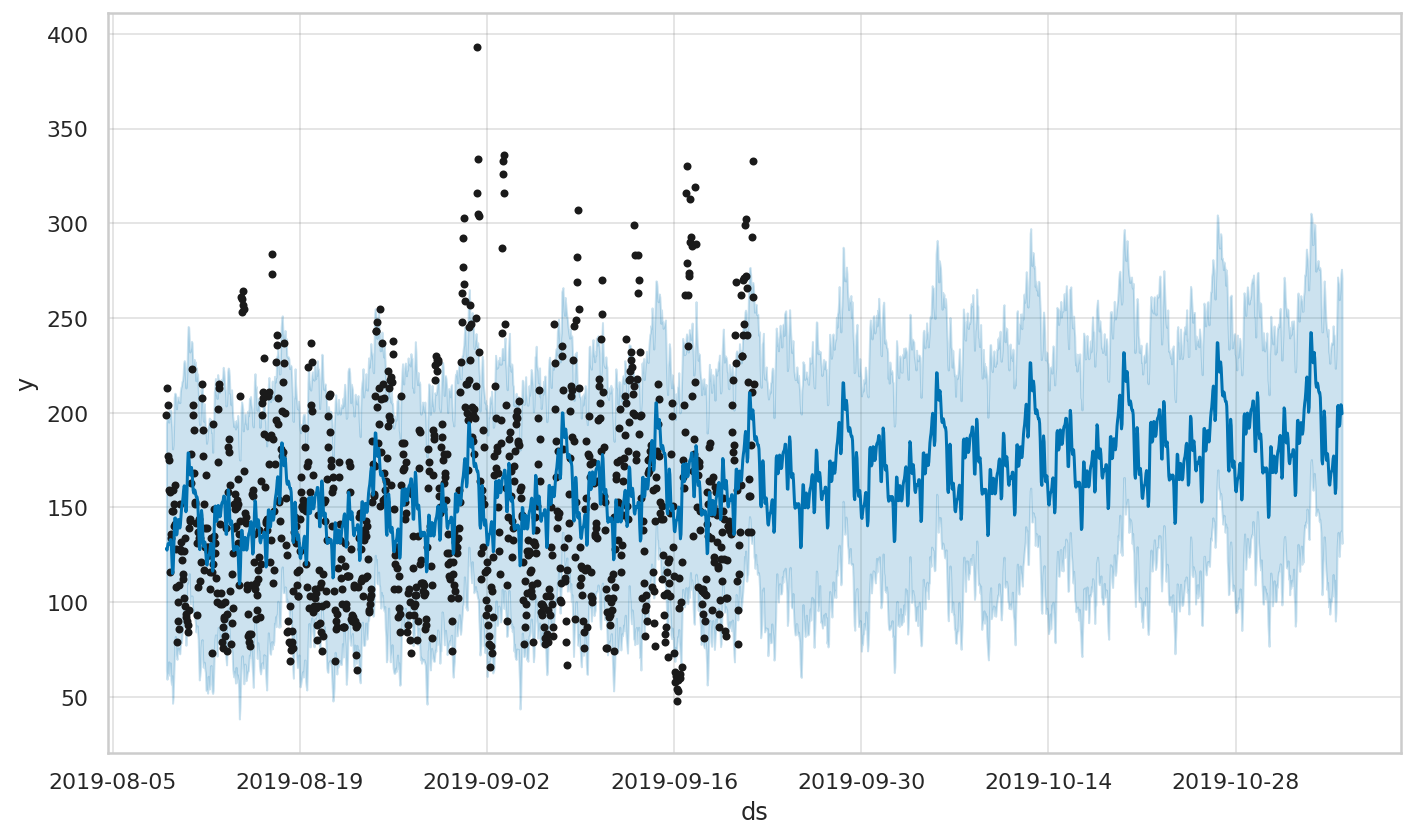

In [61]:
m = Prophet(changepoint_prior_scale=best_params.get('changepoint_prior_scale'),seasonality_prior_scale= best_params.get('seasonality_prior_scale'),changepoint_range=0.95,seasonality_mode='multiplicative').fit(df1)
future = m.make_future_dataframe(periods=1056, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

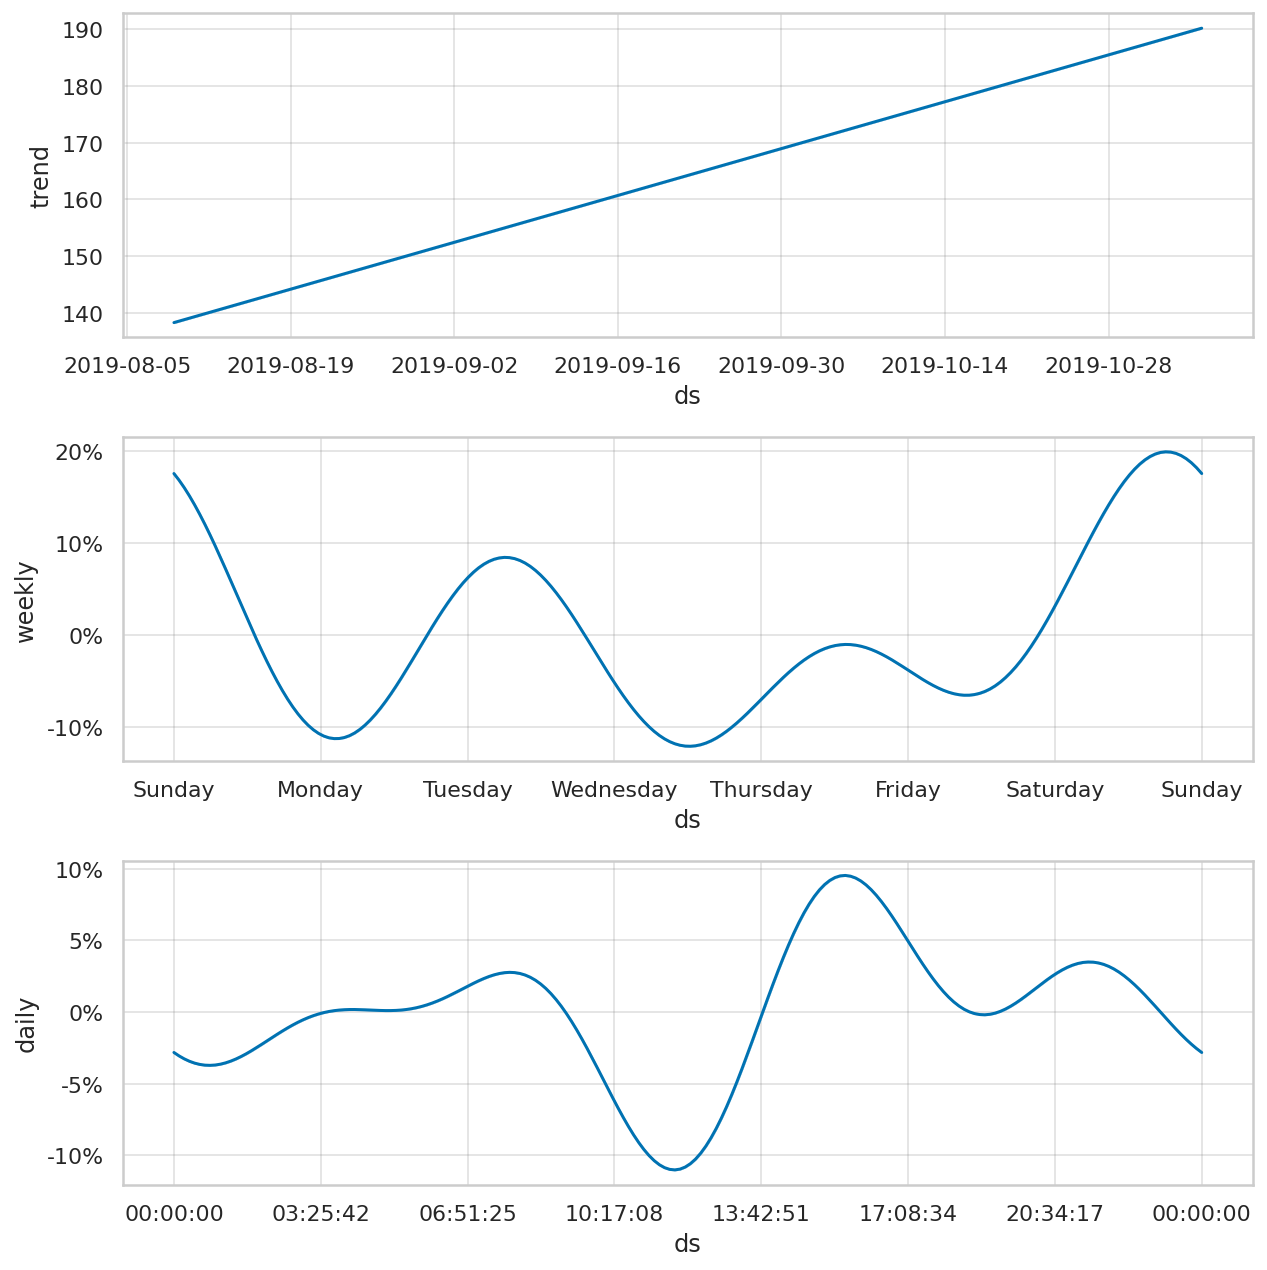

In [14]:
fig = m.plot_components(fcst)

In [ ]:
# future.to_csv('future.csv')

In [15]:
forecast1 = m.predict(future)

In [ ]:
# Filtered=forecast1.iloc[-168:]


In [ ]:
# patient_116_Aug=Filtered[['ds', 'yhat','yhat_upper','yhat_lower']]

In [16]:
patient_116_Aug=forecast1[['ds', 'yhat']]

In [17]:
patient_116_Aug

,ds,yhat
0,2019-08-09 00:16:00,128.305474
1,2019-08-09 01:16:00,127.476261
2,2019-08-09 02:16:00,129.211755
3,2019-08-09 03:16:00,130.884602
4,2019-08-09 04:16:00,130.978086
...,...,...
2106,2019-11-04 19:16:00,193.835192
2107,2019-11-04 20:16:00,199.530922
2108,2019-11-04 21:16:00,204.219221
2109,2019-11-04 22:16:00,203.783688


In [ ]:
# threshold_list_upper=[]
# threshold_list_lower=[]
# # threshold_list_upper=list(df1.iloc[-120:].values)

In [ ]:
# THRESHOLD_upper = np.mean(df1[-168:])+(2*np.std(df1[-168:]))
# THRESHOLD_lower = np.mean(df1[-168:])-(2*np.std(df1[-168:]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3332: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



In [ ]:
# patient_116_Aug['THRESHOLD_upper'] = int(THRESHOLD_upper)
# patient_116_Aug['THRESHOLD_lower'] = int(THRESHOLD_lower)

# patient_116_Aug['Anomaly'] = (patient_116_Aug.yhat >= patient_116_Aug.THRESHOLD_upper) | (patient_116_Aug.yhat <= patient_116_Aug.THRESHOLD_lower)



In [ ]:
patient_116_Aug

,ds,yhat,yhat_upper,yhat_lower,THRESHOLD_upper,THRESHOLD_lower,Anomaly
1366,2019-10-05 00:16:00,181.815588,244.127247,113.840306,280,62,False
1367,2019-10-05 01:16:00,181.487566,248.277751,108.087616,280,62,False
1368,2019-10-05 02:16:00,181.400024,249.355147,111.675127,280,62,False
1369,2019-10-05 03:16:00,180.251788,245.776112,112.210540,280,62,False
1370,2019-10-05 04:16:00,177.203637,243.126311,111.586018,280,62,False
...,...,...,...,...,...,...,...
1529,2019-10-11 19:16:00,153.250345,224.163363,83.108995,280,62,False
1530,2019-10-11 20:16:00,161.097708,229.769217,94.796021,280,62,False
1531,2019-10-11 21:16:00,171.734729,233.805458,106.828111,280,62,False
1532,2019-10-11 22:16:00,179.489417,245.566984,115.285700,280,62,False


In [ ]:
# patient_116_Aug.to_csv("patient_205_Prophet_predictions.csv")

In [18]:
 patient_116_Aug.to_csv("patient_188_Aug.csv")

In [19]:
df = pd.read_csv('patient_188_Aug.csv')

In [20]:
df.head()

,Unnamed: 0,ds,yhat
0,0,2019-08-09 00:16:00,128.305474
1,1,2019-08-09 01:16:00,127.476261
2,2,2019-08-09 02:16:00,129.211755
3,3,2019-08-09 03:16:00,130.884602
4,4,2019-08-09 04:16:00,130.978086


In [21]:
df.drop(columns='Unnamed: 0',inplace=True)
df.rename(columns={'yhat':'y'},inplace=True)
df1=df.copy()

In [22]:
df1.set_index('ds', inplace=True)
df1.head()

,y
ds,
2019-08-09 00:16:00,128.305474
2019-08-09 01:16:00,127.476261
2019-08-09 02:16:00,129.211755
2019-08-09 03:16:00,130.884602
2019-08-09 04:16:00,130.978086


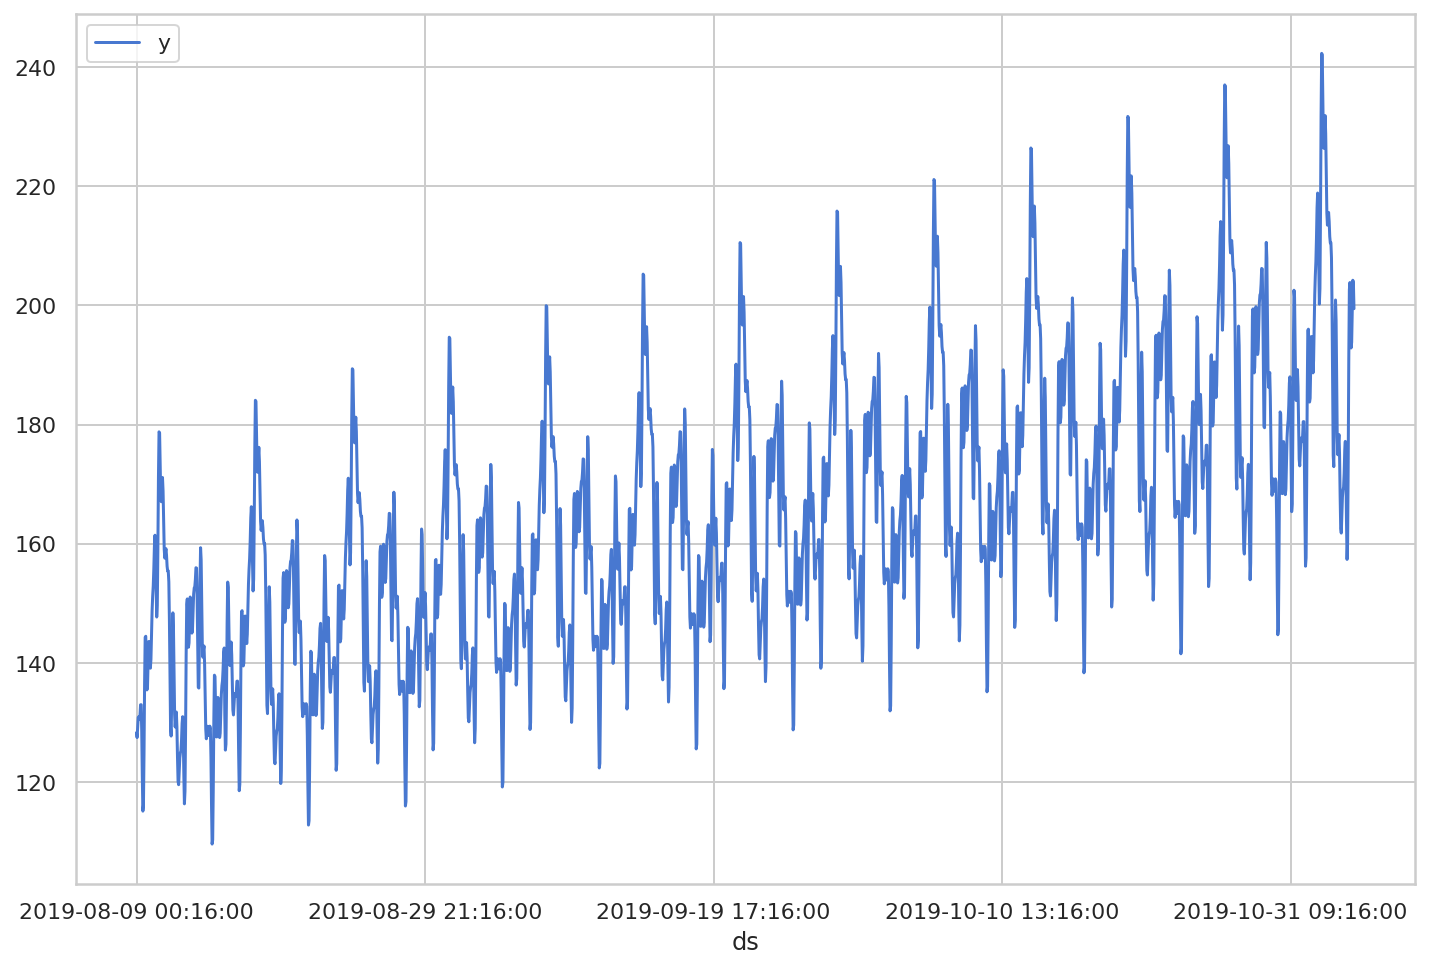

In [23]:
df1.plot(figsize=(12,8))

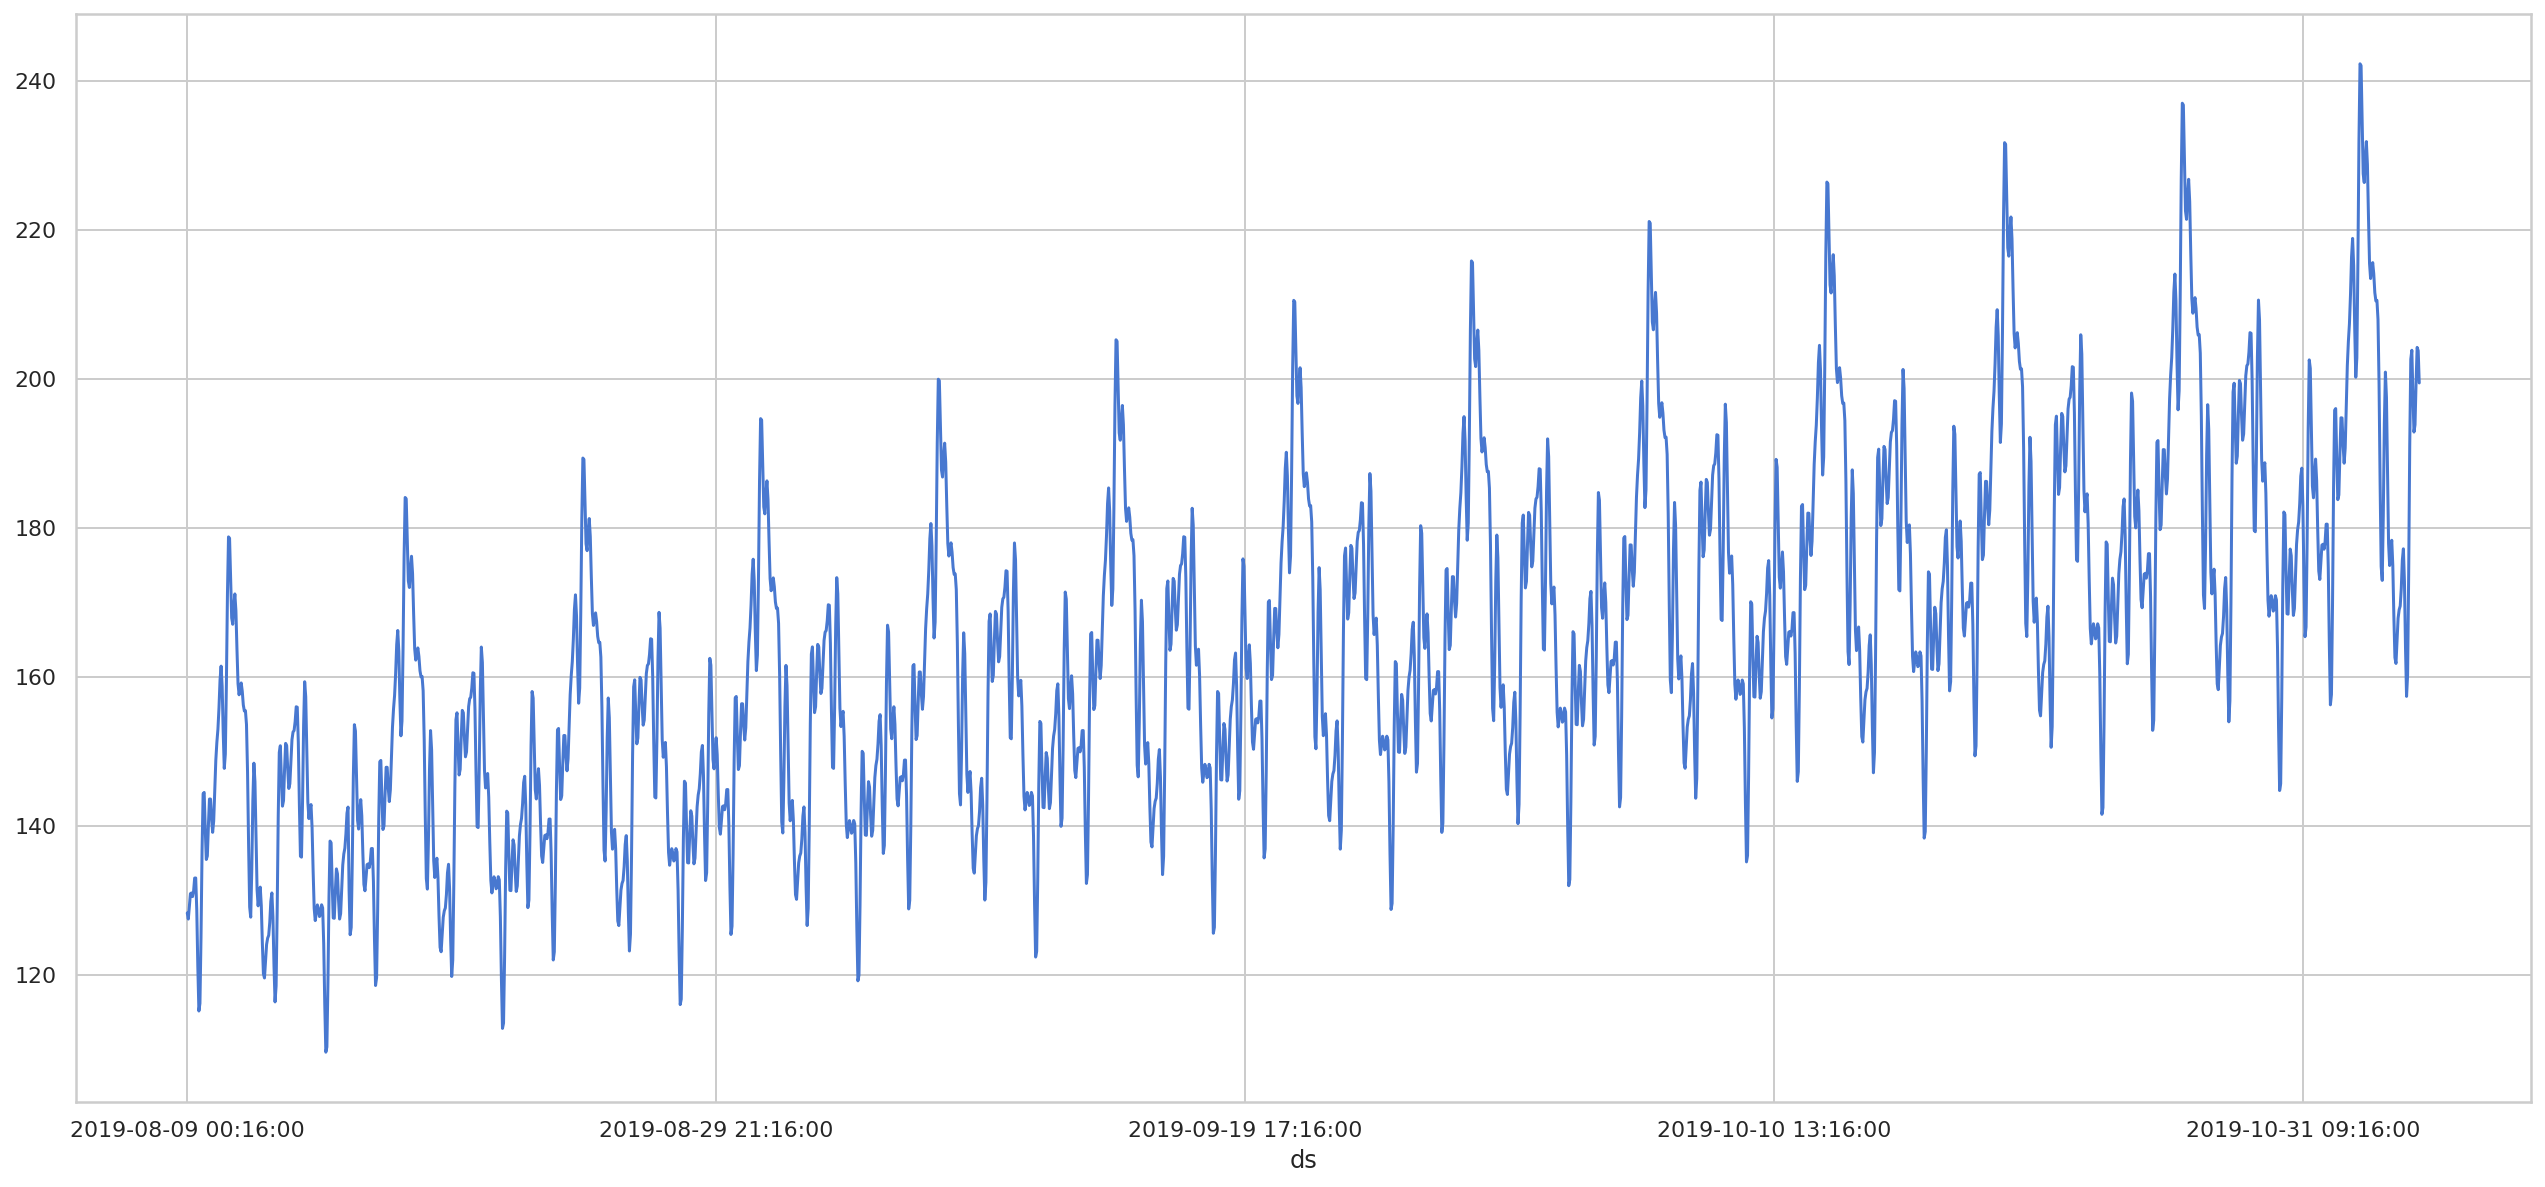

In [24]:
decomposition = seasonal_decompose(df1.y, freq=30)
decomposition.observed.plot()

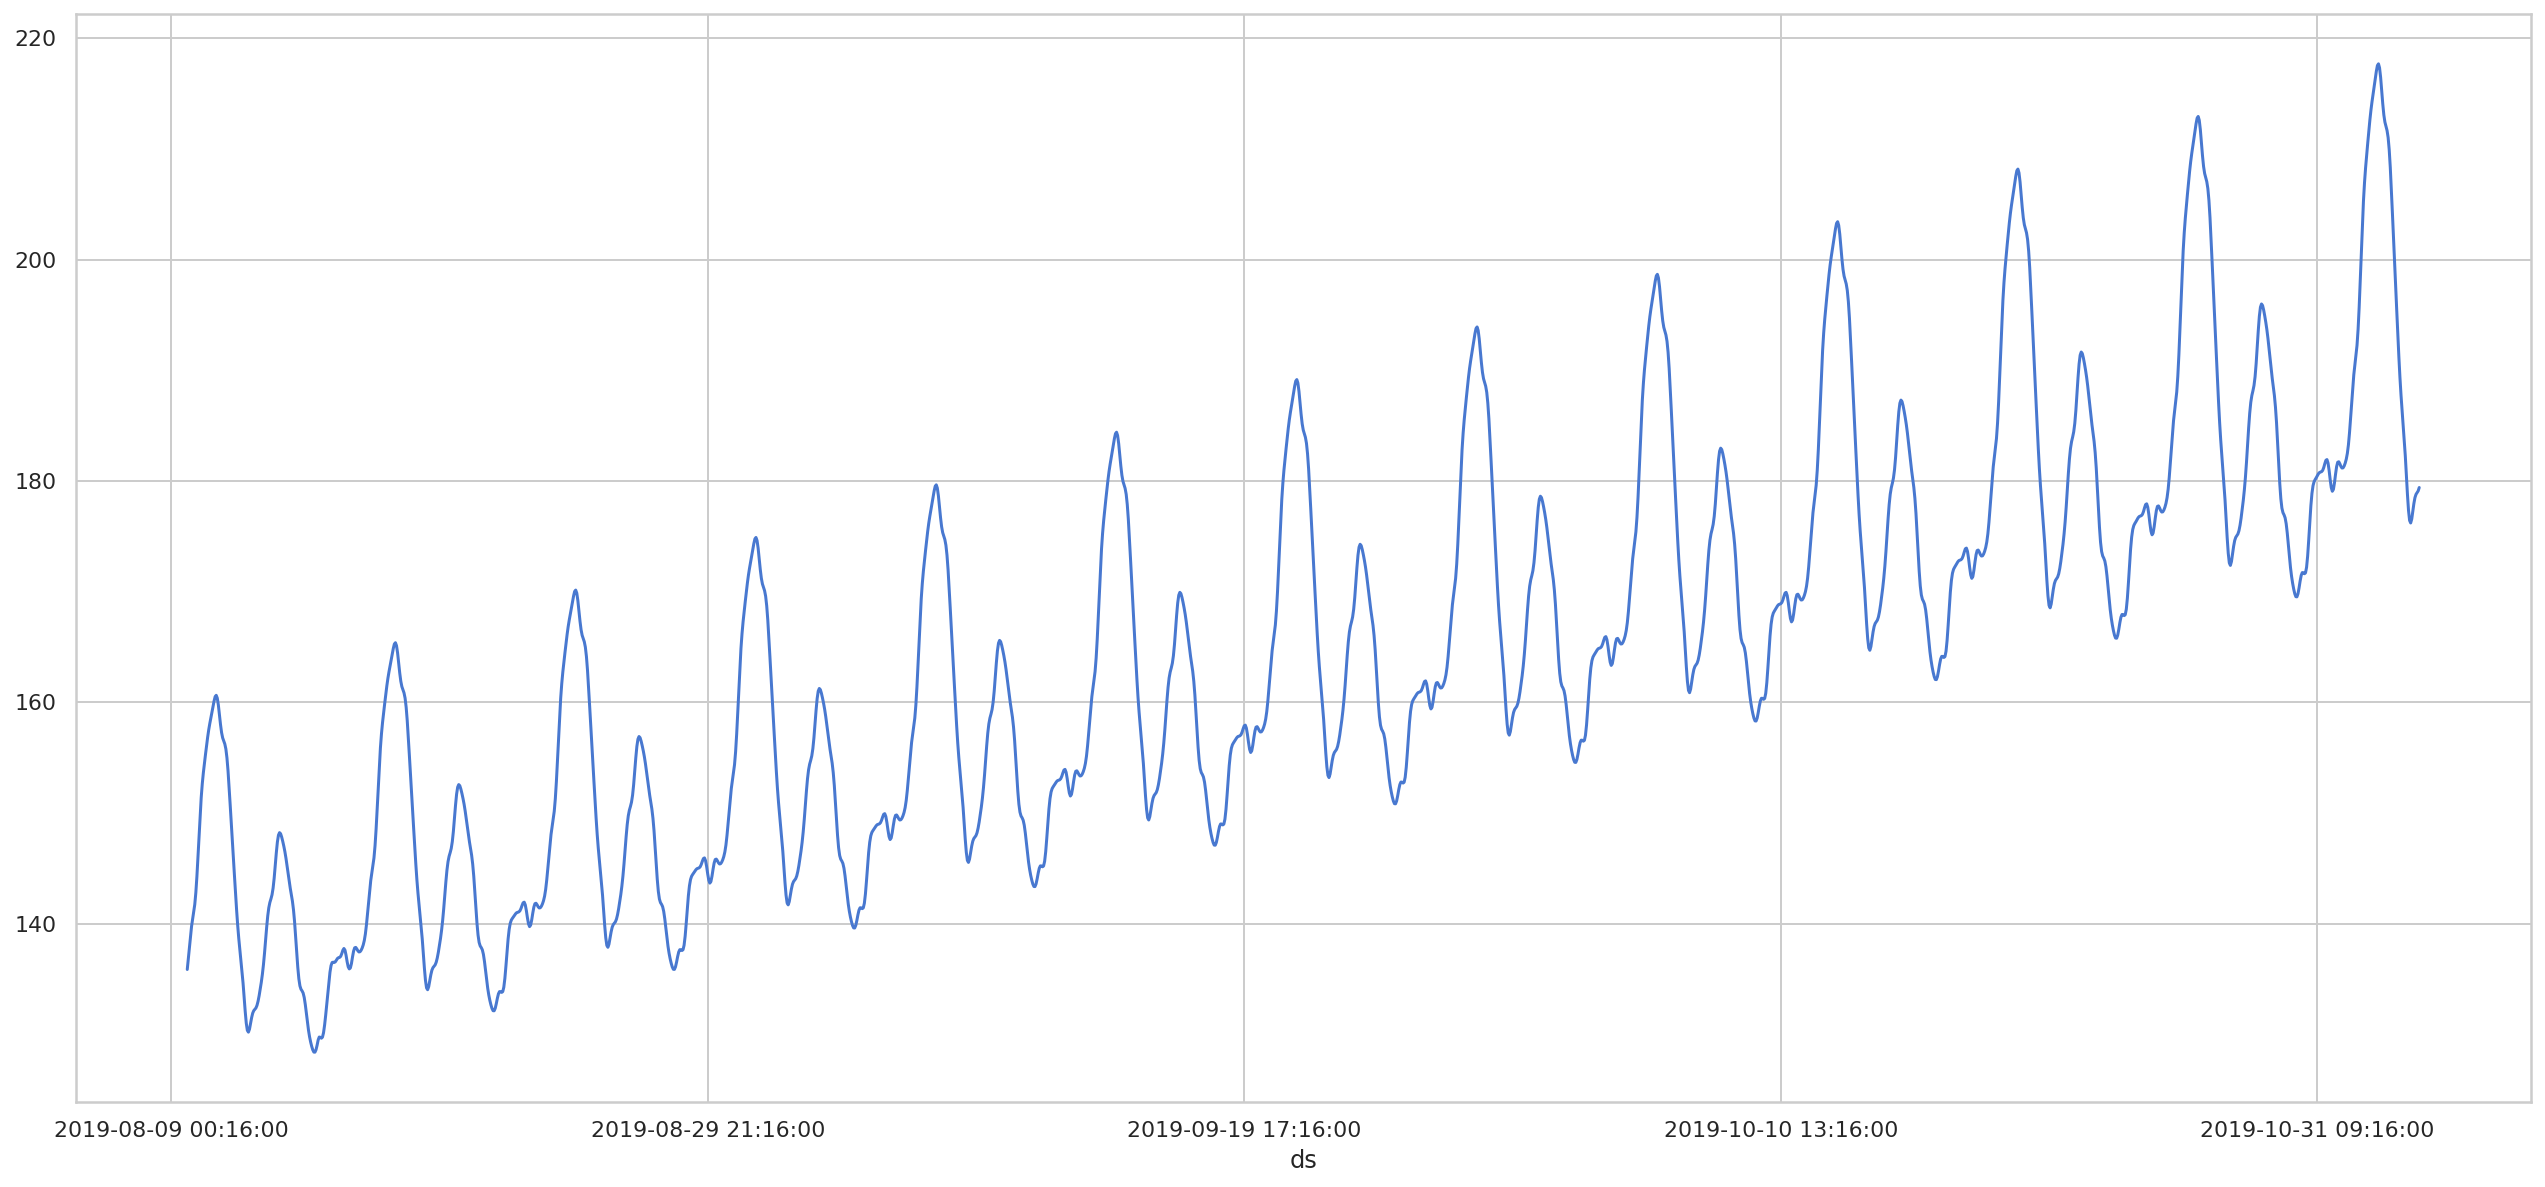

In [25]:
decomposition.trend.plot()

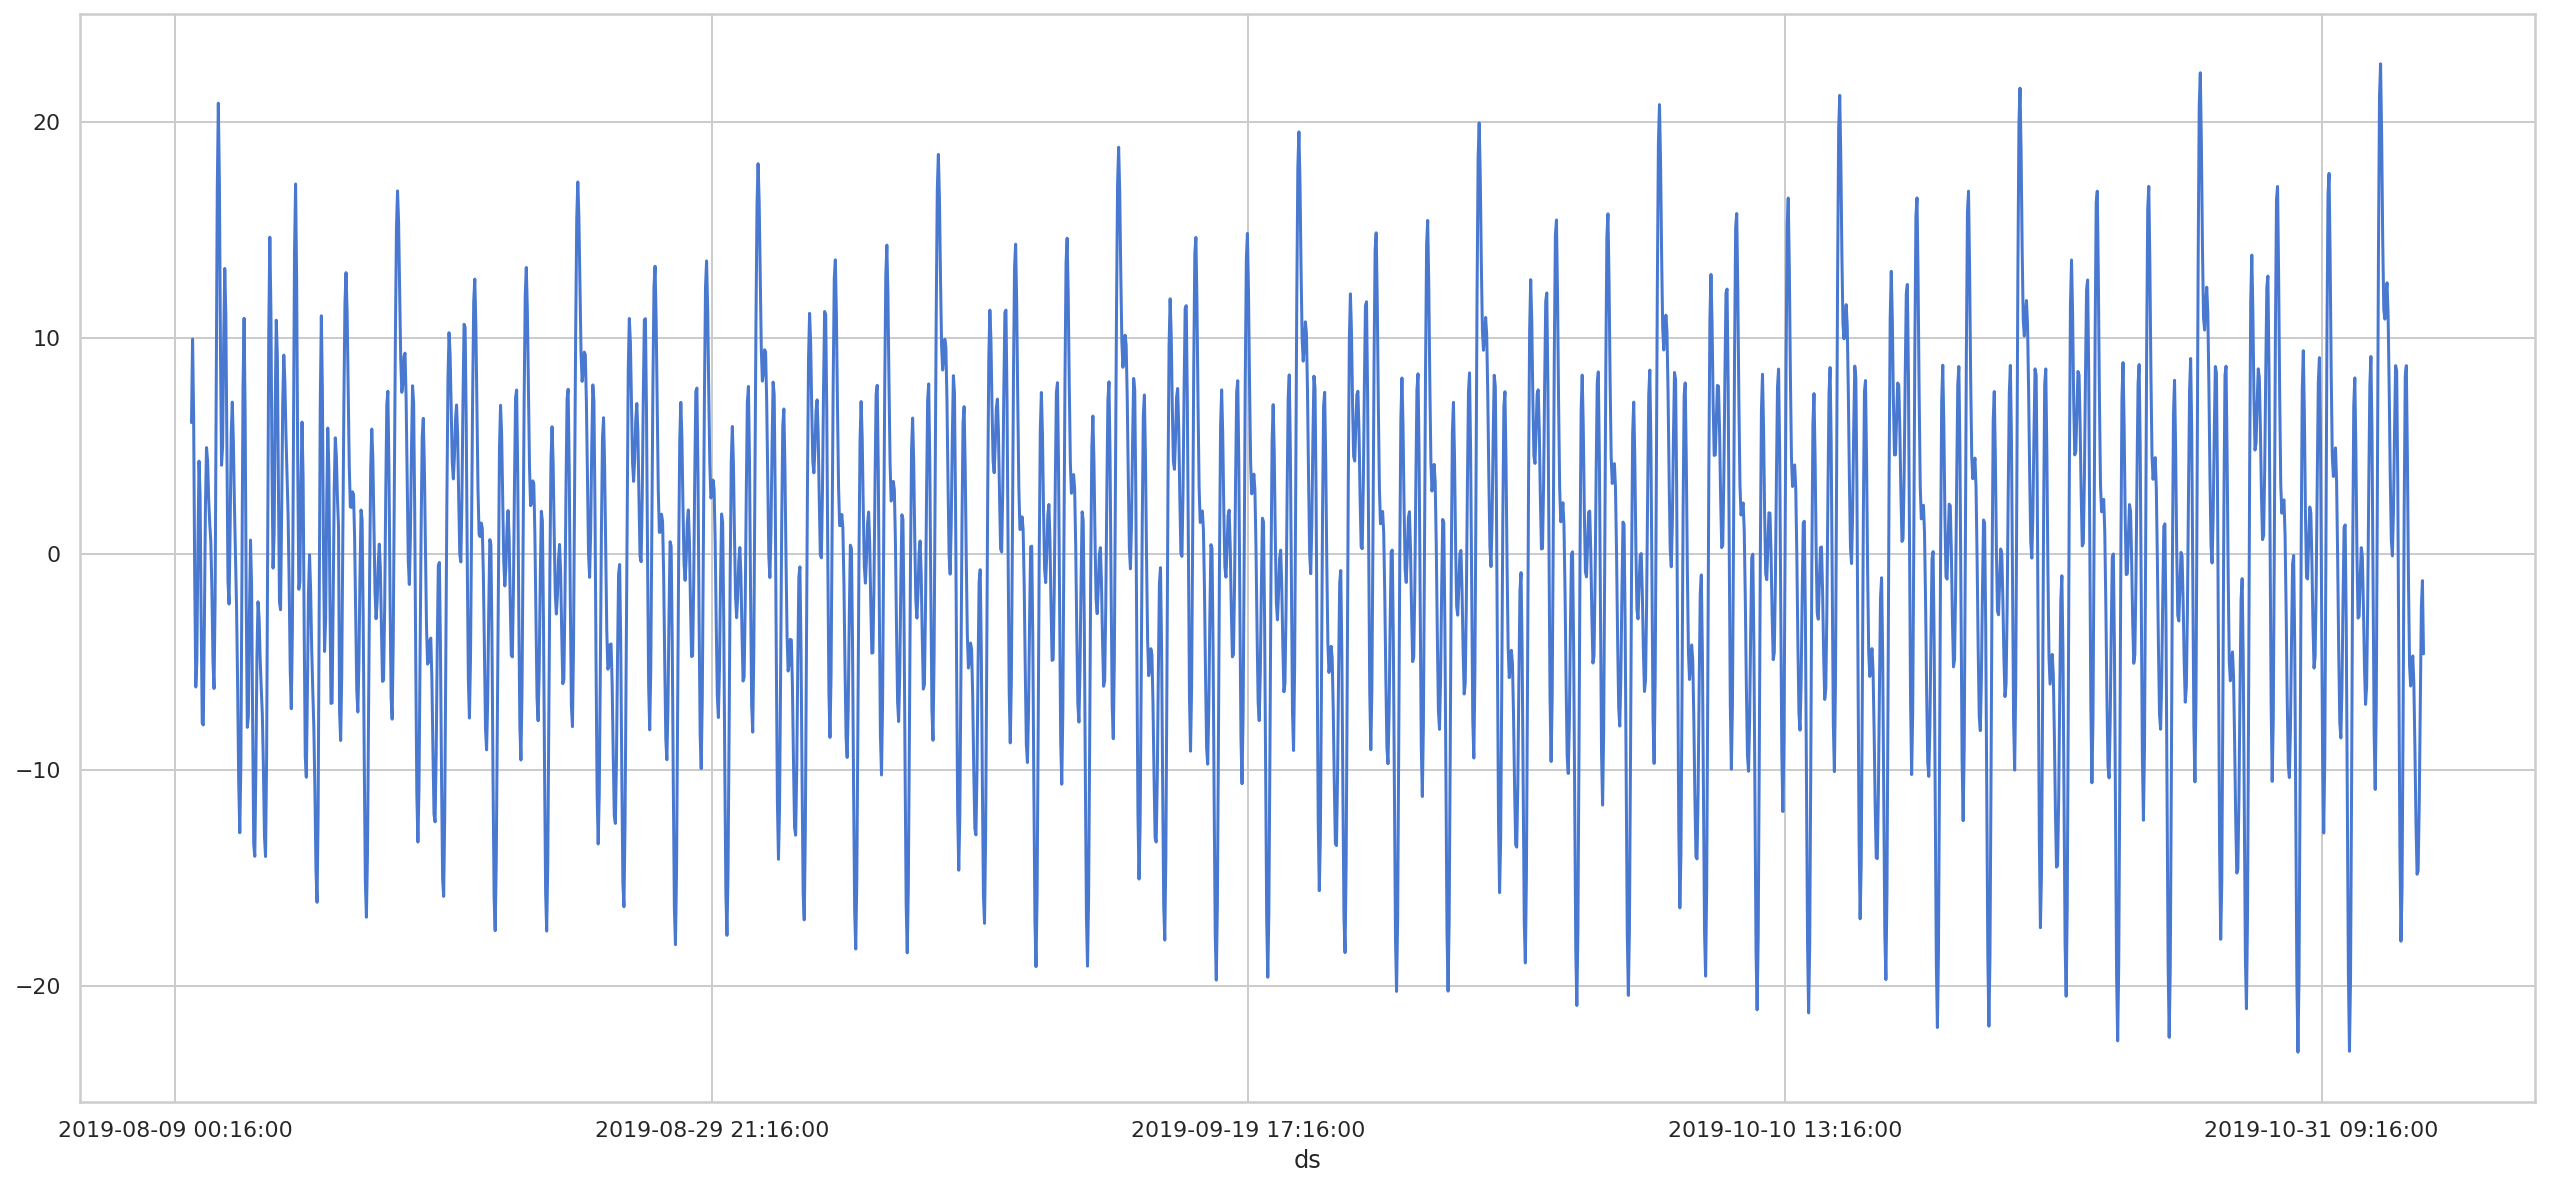

In [26]:
decomposition.resid.plot()

# Time Series - Feature Selection

Testing with expandind window

Naveen, I moved Forecasting section, which contains codes deactivated by #, to the end of this file

In [27]:
train_size = int(len(df1) * 0.8)
test_size = len(df1) - train_size
train, test = df1.iloc[0:train_size], df1.iloc[train_size:len(df1)]
print(len(train), len(test))

1688 423


In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler = scaler.fit(train[['y']])

train['y'] = scaler.transform(train[['y']])
test['y'] = scaler.transform(test[['y']])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# time_steps = 3
# generator_train = TimeseriesGenerator(train['y'], train['y'], length=time_steps, batch_size=1,stride=3)
# time_steps = 3
# generator_test= TimeseriesGenerator(test['y'], test['y'], length=time_steps, batch_size=1,stride=3)

(array([[0.62135509],
        [0.64250885],
        [0.66617642]]), 0.6750388664728537, array([[0.67503887],
        [0.65784069],
        [0.62799615]]), 0.6075527533032754)

In [29]:
#Create a Method to create a sequence to data
def create_dataset(X, y, time_steps,stride):
    Xs, ys = [], []
    for i in range(len(X) - time_steps-(stride-1)):
      if(i==0):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
      else:
        v = X.iloc[i+(stride-1):(i + time_steps+(stride-1))].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps+(stride-1)])
    return np.array(Xs), np.array(ys)

In [ ]:
# define generator
# time_steps =3
# generator_train = TimeseriesGenerator(train['y'], train['y'], length=time_steps, batch_size=1,stride=1)
# time_steps =3
# generator_test = TimeseriesGenerator(train['y'], train['y'], length=time_steps, batch_size=1,stride=1)

In [30]:
#Call the create sequence method and defile the number of time steps we want to include
time_steps =168
stride=0
# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.y, time_steps,stride)
X_test, y_test = create_dataset(test, test.y, time_steps,stride)

print(X_train.shape, y_train.shape)

(1521, 168, 1) (1521,)


In [ ]:
# # multi-step data preparation
# from numpy import array
 
# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps_in, n_steps_out):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps_in
# 		out_end_ix = end_ix + n_steps_out
# 		# check if we are beyond the sequence
# 		if out_end_ix > len(sequence):
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)
 

# # choose a number of time steps
# n_steps_in, n_steps_out = 120, 48
# # split into samples
# X_train, y_train = split_sequence(train['y'], n_steps_in, n_steps_out)
# X_test, y_test = split_sequence(test['y'] , n_steps_in, n_steps_out)


In [32]:
X_train.shape

(1521, 168, 1)

(577, 7, 1) (577,)

# Model Tuning

In [ ]:
# n_features=1
# X_train= X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
# X_test= X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [ ]:
X_train.shape

(1353, 168, 1)

In [ ]:
X_train.shape

(1353, 168, 1)

In [121]:
def build_model(hp):   
     
      model = keras.Sequential()
      model.add(
        keras.layers.Bidirectional(
          keras.layers.LSTM(
            units=hp.Int('Layer_1',min_value=32,max_value=1024,step=32), 
             activation=hp.Choice('activation1',values=['relu','tanh','softplus','elu'],default='relu'),
            input_shape=(X_train.shape[1], X_train.shape[2])
           
          )
        )
      )
      model.add(keras.layers.Dropout(hp.Float(
                    'dropout_1',
                    min_value=0.0,
                    max_value=0.3,
                    default=0.005,
                    step=0.01)
            ))
      model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
      model.add(keras.layers.LSTM(units=hp.Int('Layer_2',min_value=32,max_value=1024,step=32),activation=hp.Choice('activation2',values=['relu','tanh','softplus','elu'],default='relu')))
      model.add(keras.layers.Dropout(hp.Float(
                    'dropout_2',
                    min_value=0.0,
                    max_value=0.3,
                    default=0.005,
                    step=0.01)
            ))
      model.add(keras.layers.Dense(units=1))
      model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',metrics=['mse'])
      return model

In [122]:
#Set the Tuning Parameters
tuner = RandomSearch(
    build_model,
    objective='mse',
    max_trials=5,
    executions_per_trial=5,
    directory='my_TunerNew434',
    project_name='GlucosePredictions')

In [123]:
tuner.search_space_summary()

In [ ]:
#Start Searching the best hyperparameters
tuner.search(X_train, y_train,
             epochs=10,
             validation_split=0.2,verbose=0)

In [ ]:
df1

In [ ]:
#Get the 1st Best model amoung all 10 models
best_model = tuner.get_best_models(num_models=1)[0]
loss, mse = best_model.evaluate(X_test, y_test)

# Model Evaluation

In [ ]:
tuner.results_summary()

In [ ]:
best_model.summary()

In [ ]:
# model = keras.Sequential()
# model.add(keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.LSTM(50, activation='relu'))
# model.add(keras.layers.Dense(units=1))
# model.compile(optimizer='adam', loss='mse')
# # fit model
# # model.fit(X, y, epochs=40, verbose=1)

In [ ]:
#Now using the best model, fit it to our training data
history = best_model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1, 
    shuffle=False
)

In [ ]:
#plotting loss function vs epochs
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Means Squared Error")
plt.title("Learning curve Daignosis")
plt.legend();

# Save The Model

In [ ]:
pip install h5py

In [ ]:
model=best_model

In [ ]:
# from keras.models import model_from_json
# # serialize model to JSON
# LSTM_model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(LSTM_model_json)
# # serialize weights to HDF5
# model.save_weights("LSTM_model.h5")
# print("Saved model to disk")

In [ ]:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("LSTM_model.h5")
# print("Loaded model from disk")

# 2nd Way to save as a single file

In [ ]:
# save model and architecture to single file
model.save("patient_new_hourly.h5")
print("Saved model to disk")

In [ ]:
from keras.models import load_model
loaded_model=load_model('patient_new_hourly.h5')

# Prediction - Anomalies Detection

In [ ]:
y_pred = loaded_model.predict(X_test)

In [ ]:
# # reshape into [1, n_input, 1]
# input_x = X_test[-1].reshape((1, len(X_test[-1]), 1))
# # forecast the next week
# yhat = model.predict(input_x, verbose=0)
# # we only want the vector forecast
# yhat = yhat[0]



Inverse the data that was scaled using standard scaler

In [ ]:
y_train_inv = scaler.inverse_transform(y_train.reshape(1, -1))
y_test_inv = scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = scaler.inverse_transform(y_pred)

In [ ]:
#Calculate RMSE for both training and testing
from sklearn.metrics import  mean_squared_error
import math
trainPredict = loaded_model.predict(X_train)
testPredict = loaded_model.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MSE' % (testScore))

In [ ]:
# Threshold_upper=[]
# THRESHOLD_upper = np.mean(y_test[-168:])+(2*np.std(y_train_inv[-168:]))
# THRESHOLD_lower=np.mean(y_test[-168:])-(2*np.std(y_train_inv[-168:]))
# mean=np.mean(y_train_inv)

Calculate threshold for each Bucket, using mean+2(std).

Plot training, testing and predicted data along with the treshold's for each bucket.

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
# plt.axhline(y=THRESHOLD_Upper, color='r', linestyle='-',label='THRESHOLD_Upper')
# plt.axhline(y=THRESHOLD_lower, color='b', linestyle='-',label='THRESHOLD_lower')
# # plt.axhline(y=THRESHOLD_bucket3, color='g', linestyle='-',label='THRESHOLD_bucket3')
# # plt.axhline(y=THRESHOLD_bucket4, color='y', linestyle='-',label='THRESHOLD_bucket4')
plt.ylabel('Glucose Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")

plt.ylabel('Glucose Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Generating 28 future predictions

In [ ]:
n_steps=X_train.shape[1]
n_features=X_train.shape[2]
# demonstrate prediction for next 14 days
# a=df1.y[-14:]
c=pd.DataFrame()
b=df1.y[-168:]

x_input = np.array(b)
temp_input=list(x_input)
lst_output=[]
i=0
while(i<168):
    
    if(len(temp_input)>168):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = loaded_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = loaded_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

print(lst_output)

In [ ]:
#Create a data range just to show in X-axis and y_axis
# a=pd.date_range(start="2018-07-31",end="2019-06-02")
# v=np.array(a)
# len(v)
# a=pd.date_range(start="2019-06-02",end="2019-11-16")
# u=np.array(a)
# len(u)


In [ ]:
lst_output=np.array(lst_output)
lst_output=lst_output.reshape(1,-1)

In [ ]:

y_pred_inv1 = scaler.inverse_transform(lst_output)

In [ ]:
day_new=np.arange(1,len(y_test_inv.flatten())+1)
day_pred=np.arange(len(y_test_inv.flatten())+1,len(y_test_inv.flatten())+len(y_pred_inv1.flatten())+1)


In [ ]:
# day_new=np.arange(1,len(df1.y[-168:])+1)
# day_pred=np.arange(len(df1.y[-168:])+1,len(df1.y[-168:])+len(y_pred_inv1.flatten())+1)


Plot the Future predictions generated above post the test data sequence

In [ ]:
threshold_list_upper=[]
threshold_list_lower=[]
threshold_list_upper=list(y_test_inv.flatten())


In [ ]:
THRESHOLD_upper = np.mean(threshold_list_upper[-120:])+(2*np.std(threshold_list_upper[-120:]))
THRESHOLD_lower = np.mean(threshold_list_upper[-120:])-(2*np.std(threshold_list_upper[-120:]))
THRESHOLD_lower

plt.plot(day_new, df1.y[-168:].values, marker='.', label="Test")

In [ ]:
plt.plot(day_new, y_test_inv.flatten(), marker='.', label="Test")
plt.plot(day_pred,y_pred_inv1.flatten(), 'r',marker='*', label="prediction")
plt.axhline(y=THRESHOLD_upper, color='r', linestyle='-',label='THRESHOLD_upper')
# plt.axhline(y=Mean, color='b', linestyle='-',label='Mean')
plt.axhline(y=THRESHOLD_lower, color='g', linestyle='-',label='THRESHOLD_lower')
# plt.axhline(y=THRESHOLD_bucket4, color='y', linestyle='-',label='THRESHOLD_bucket4')

plt.ylabel('Glucose Value')
plt.xlabel('Time Step')
plt.legend()
plt.title("Next 7 days Predicted Values")
plt.show();

In [ ]:
# plt.plot(day_new,y_test_inv1)
# plt.plot(day_pred,y_pred_inv1)
# plt.title("True VS Predicted")

Function to calculate confidence interval

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

#some example data
x= np.arange(1,169)
y = y_pred_inv1.flatten()
#some confidence interval
ci = 1.96 * np.std(y)/np.mean(y)

fig, ax = plt.subplots()
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

In [ ]:
# import numpy as np
# import scipy.stats
# confidence=0.95
# a =1 * np.array(y_train_inv.flatten())
# n = len(a)
# m, se = np.mean(a), scipy.stats.sem(a)
# h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
# # return m, m-h, m+h

Plot the confidence interval just for the predicted data

In [ ]:
# import numpy as np
# import scipy.stats


# def mean_confidence_interval(data, confidence=0.95):
#     a = 1.0 * np.array(data)
#     n = len(a)
#     m, se = np.mean(a), scipy.stats.sem(a)
#     h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#     return m, m-h, m+h

In [ ]:
# mean_confidence_interval(y_pred_inv1.flatten(),confidence)

In [ ]:
# from matplotlib import pyplot as plt
# import numpy as np

# #some example data
# x= np.arange(1,169)
# y = y_pred_inv1.flatten()
# #some confidence interval
# # ci = 20 * np.std(y)/np.mean(y)

# fig, ax = plt.subplots()
# ax.plot(x,y)
# ax.fill_between(x, (y-h), (y+h), color='b', alpha=.1)

In [ ]:
Patient_116_analysis = pd.DataFrame()
Patient_116_analysis['Prediction'] = y_pred_inv1.flatten()
Patient_116_analysis['THRESHOLD_upper'] = THRESHOLD_upper
Patient_116_analysis['THRESHOLD_lower'] = THRESHOLD_lower

Patient_116_analysis['Anomaly'] = (Patient_116_analysis.Prediction >= Patient_116_analysis.THRESHOLD_upper) | (Patient_116_analysis.Prediction <= Patient_116_analysis.THRESHOLD_lower)
Patient_116_analysis['Confidence'] =ci 
Patient_116_analysis['Upper_bound'] = y+ci
Patient_116_analysis['Lower_bound'] = y-ci
Patient_116_analysis['Train_MSE']=trainScore
Patient_116_analysis['Test_MSE']=testScore


In [ ]:
Patient_116_analysis.head()

In [ ]:
Patient_116_analysis.to_csv('Analysis_188_new.csv')

In [ ]:

# # univariate lstm example
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Flatten

In [ ]:
# def prepare_data(timeseries_data, n_features):
# 	X, y =[],[]
# 	for i in range(len(timeseries_data)):
# 		# find the end of this pattern
# 		end_ix = i + n_features
# 		# check if we are beyond the sequence
# 		if end_ix > len(timeseries_data)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return np.array(X), np.array(y)

In [ ]:
# n_steps = 14
# # split into samples
# X, y = prepare_data(rolling_mean.y, n_steps)

In [ ]:

# # reshape from [samples, timesteps] into [samples, timesteps, features]
# n_features = 1
# X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
# train_size = int(len(rolling_mean) * 0.8)
# test_size = len(rolling_mean) - train_size
# train, test = rolling_mean.iloc[0:train_size], rolling_mean.iloc[train_size:len(rolling_mean)]
# print(len(train), len(test))

In [ ]:
# def create_dataset(X, y, time_steps=1):
#     Xs, ys = [], []
#     for i in range(len(X) - time_steps):
#         v = X.iloc[i:(i + time_steps)].values
#         Xs.append(v)        
#         ys.append(y.iloc[i + time_steps])
#     return np.array(Xs), np.array(ys)

In [ ]:
# time_steps =14
# n_steps=time_steps
# n_features=1
# # reshape to [samples, time_steps, n_features]

# X_train, y_train = create_dataset(train, train.y, time_steps)
# X_test, y_test = create_dataset(test, test.y, time_steps)

# print(X_train.shape, y_train.shape)

In [ ]:

# # define model
# model = Sequential()
# model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
# model.add(LSTM(50, activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit(X, y, epochs=50, verbose=1)

In [ ]:
# # fit model
# history = model.fit(
#     X_train, y_train, 
#     epochs=50, 
#     batch_size=8, 
#     validation_split=0.1, 
#     verbose=1, 
#     shuffle=False
# )

In [ ]:
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend();

In [ ]:
# a=df1.y[-14:]
# len(a)

In [ ]:

# # demonstrate prediction for next 14 days
# a=rolling_mean.y[-14:]
# x_input = np.array(a)
# temp_input=list(x_input)
# lst_output=[]
# i=0
# while(i<14):
    
#     if(len(temp_input)>14):
#         x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
#         #print(x_input)
#         x_input = x_input.reshape((1, n_steps, n_features))
#         #print(x_input)
#         yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
#         temp_input.append(yhat[0][0])
#         temp_input=temp_input[1:]
#         #print(temp_input)
#         lst_output.append(yhat[0][0])
#         i=i+1
#     else:
#         x_input = x_input.reshape((1, n_steps, n_features))
#         yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
#         temp_input.append(yhat[0][0])
#         lst_output.append(yhat[0][0])
#         i=i+1
    

# print(lst_output)

In [ ]:

# import matplotlib.pyplot as plt

In [ ]:

# day_new=np.arange(1,15)
# day_pred=np.arange(15,29)

In [ ]:
#@title 
# plt.plot(day_new,a)
# plt.plot(day_pred,lst_output)

In [ ]:
# rolling_mean.dtypes